### Imports

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy.stats import probplot, t, jarque_bera, normaltest, kstest, ttest_1samp
import statsmodels.api as sm
import seaborn as sns
from sklearn.mixture import GaussianMixture

%matplotlib inline

### Functions and Classes

In [8]:
def return_calculator(df,t):
    df["prev_close"] = df["close"].shift(t)
    df["return"] = df["close"]/df["prev_close"]-1
#     df["return2"] = df["close"].pct_change(t)
    df["log_return"] = np.log(df["return"]+1)
    return df

def return_calculator_batch(df,symbols,t=1):
    for symbol in symbols:
        df[symbol+"_prev"] = df[symbol].shift(t)
        df[symbol+"_ret"]  = df[symbol]/df[symbol+"_prev"]-1
        df[symbol+"_logret"] = np.log(df[symbol+"_ret"]+1)
    return df

def return_volatiliy_plot(rets):
    plt.scatter(rets.std(), rets.mean())
    plt.xlabel("Volatility")
    plt.ylabel("Return")
    
        
class myt:
    def __init__(self,df):
        self.df = df
        
    def fit(self,x):
        return t.fit(x)
    
    def ppf(self, x, loc=0, scale=1):
        return t.ppf(x, self.df, loc, scale)
    
    
def cdf(x):
    return t.cdf(x, df, loc, scale)


def m_s_low_high_calculator(values, z = 1.96):
    m = values.mean()
    s = values.std(ddof=1)
    low   = m - z * s / np.sqrt(len(values))
    high = m + z * s / np.sqrt(len(values))
    return m, s, low, high


def t_z_score(values, alpha=0.95, mode="z"):
    df = len(values)-1 
    if mode=="t":
        v = t.ppf((1 + alpha)/2., df)
    elif mode=="z":
        alpha_prime = 1 - alpha
        alpha = 1 - (alpha_prime/2)
        v = norm.ppf(alpha)
        
    return v

### Read data

In [9]:
data = pd.read_csv("all_stocks_5yr.csv", parse_dates=True)

In [10]:
sbux = data[data["Name"]=="SBUX"].copy()

In [11]:
sbux.head()

,date,open,high,low,close,volume,Name
498152,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX
498153,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX
498154,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX
498155,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX
498156,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX


1259


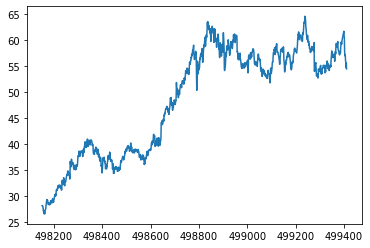

In [12]:
print(len(sbux))
sbux["close"].plot();

In [13]:
sbux = return_calculator(sbux,1)

In [14]:
# sbux["prev_close"] = sbux["close"].shift(1)
# sbux["return"] = sbux["close"]/sbux["prev_close"]-1
# sbux["return2"] = sbux["close"].pct_change(1)
# sbux["log_return"] = np.log(sbux["return"]+1)

In [15]:
sbux.head()

,date,open,high,low,close,volume,Name,prev_close,return,log_return
498152,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX,NaN,NaN,NaN
498153,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX,28.185,-0.004080,-0.004089
498154,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX,28.070,0.002138,0.002135
498155,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX,28.130,-0.007643,-0.007672
498156,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX,27.915,-0.005015,-0.005028


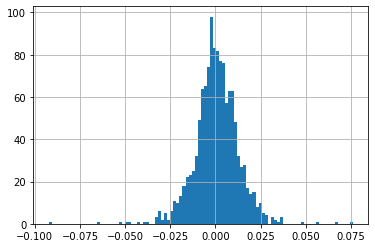

In [16]:
sbux["return"].hist(bins=100);

In [17]:
sbux["return"].mean(), sbux["return"].std()

(0.0006002332205830914, 0.012360934026133879)

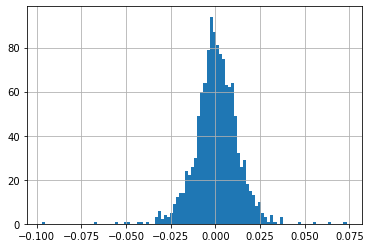

In [18]:
sbux["log_return"].hist(bins=100);

In [19]:
sbux["log_return"].mean(), sbux["log_return"].std()

(0.0005235902748108682, 0.012381234216101258)

### QQ plots

In [20]:
x_list = np.linspace(
    sbux['return'].min(),
    sbux['return'].max(),
    100
)

In [21]:
y_list = norm.pdf(x_list, loc=sbux['return'].mean(), scale=sbux['return'].std())

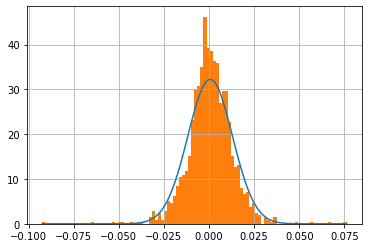

In [22]:
plt.plot(x_list, y_list);
sbux['return'].hist(bins=100, density=True);

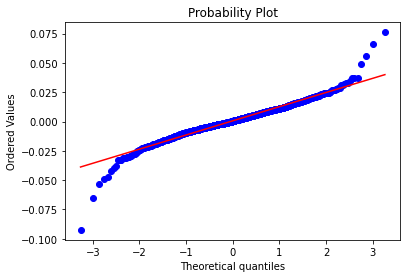

In [23]:
probplot(sbux['return'].dropna(), dist='norm', fit=True, plot=plt);

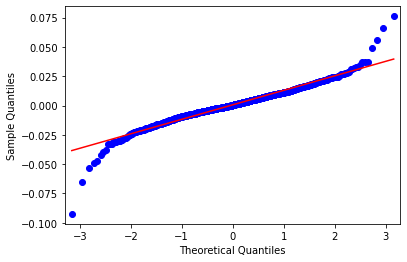

In [24]:
sm.qqplot(sbux['return'].dropna(), line='s');

In [25]:
x_list_log = np.linspace(
    sbux['log_return'].min(),
    sbux['log_return'].max(),
    100
)

In [26]:
y_list_log = norm.pdf(x_list_log, loc=sbux['log_return'].mean(), scale=sbux['log_return'].std())

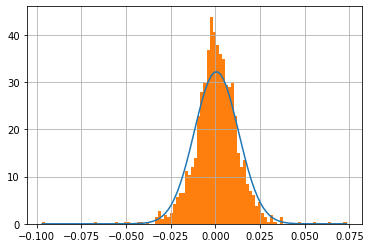

In [27]:
plt.plot(x_list_log, y_list_log);
sbux['log_return'].hist(bins=100, density=True);

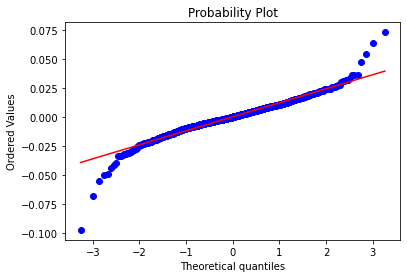

In [28]:
probplot(sbux['log_return'].dropna(), dist='norm', fit=True, plot=plt);

### t-distribution

In [29]:
params = t.fit(sbux['return'].dropna())

In [30]:
params

(4.78753221828017, 0.0007108616716254146, 0.009341981642040986)

In [31]:
df, loc, scale = params

In [32]:
y_list = t.pdf(x_list, df, loc, scale)

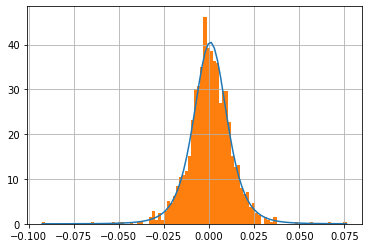

In [33]:
plt.plot(x_list, y_list);
sbux['return'].hist(bins=100,density=True);

In [34]:
# sm.qqplot(sbux['return'].dropna(), dist=t,line='s');

In [35]:
# probplot(sbux['log_return'].dropna(), dist='t', fit=True, plot=plt);

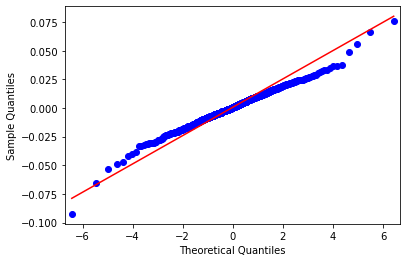

In [36]:
sm.qqplot(sbux['return'].dropna(), dist=myt(df),line='s');

In [37]:
params_log = t.fit(sbux['log_return'].dropna())

In [38]:
df_log, loc_log, scale_log = params_log

In [39]:
y_list_log = t.pdf(x_list_log, df_log, loc_log, scale_log)

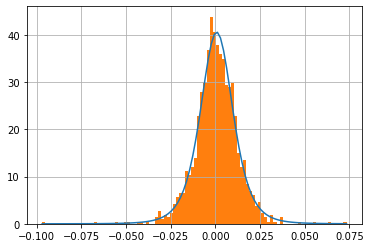

In [40]:
plt.plot(x_list_log, y_list_log);
sbux['log_return'].hist(bins=100,density=True);

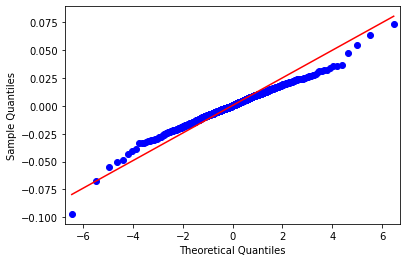

In [41]:
sm.qqplot(sbux['log_return'].dropna(), dist=myt(df_log),line='s');

### Skewness and Kurtosis

In [42]:
sbux['return'].skew()

-0.2680784195824153

In [43]:
sbux['return'].kurtosis()

5.593158903424731

In [44]:
sbux['log_return'].skew()

-0.41015501490182066

In [45]:
sbux['log_return'].kurtosis()

5.964502225799283

### Sample

In [46]:
sample = pd.Series(np.random.randn(10000))
sample.skew(), sample.kurtosis()

(-0.03487284182194453, 0.09769693610935715)

In [47]:
# these are all excess skewness and kurtosis

### Confidence Interval

In [48]:
values = sbux['return'].dropna().to_numpy()

In [49]:
t_z_value = t_z_score(values, alpha=0.95, mode="z")

In [50]:
m, s, low, high = m_s_low_high_calculator(values, z = t_z_value)

In [51]:
# 99% 2.576
# 98% 2.326
# 95% 1.96
# 90% 1.645

In [52]:
m

0.0006002332205830914

In [53]:
s

0.012360934026133879

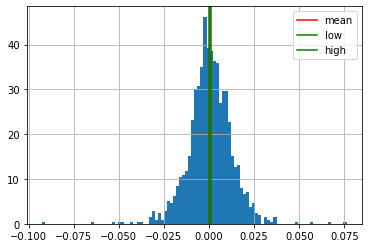

In [54]:
sbux['return'].hist(bins=100, density=True)
plt.axvline(m, label='mean', color='red')
plt.axvline(low, label='low', color='green')
plt.axvline(high, label='high', color='green')
plt.legend();

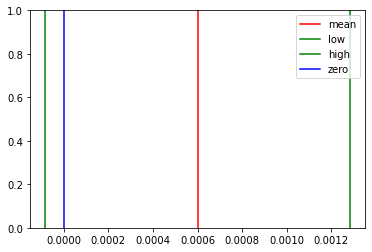

In [55]:
plt.axvline(m, label='mean', color='red')
plt.axvline(low, label='low', color='green')
plt.axvline(high, label='high', color='green')
plt.axvline(0, label='zero', color='blue')
plt.legend();

### Statistical Testing

In [56]:
jarque_bera(values)

Jarque_beraResult(statistic=1639.0284386552219, pvalue=0.0)

In [57]:
normaltest(values)

NormaltestResult(statistic=172.6819672061636, pvalue=3.1811727900119636e-38)

In [58]:
sbux_log_return = sbux["log_return"].dropna()

In [59]:
jarque_bera(sbux_log_return)

Jarque_beraResult(statistic=1882.1814629047672, pvalue=0.0)

In [60]:
normaltest(sbux_log_return)

NormaltestResult(statistic=198.54738937007733, pvalue=7.690989175882069e-44)

In [61]:
df, loc, scale = t.fit(values)

In [62]:
kstest(sbux_log_return, cdf)

KstestResult(statistic=0.0188777982808932, pvalue=0.7536559316133509)

In [63]:
df, loc, scale = t.fit(sbux_log_return)

In [64]:
kstest(sbux_log_return, cdf)

KstestResult(statistic=0.01837990941957013, pvalue=0.7818301159274575)

In [65]:
ttest_1samp(values, 0)

Ttest_1sampResult(statistic=1.7223010261810556, pvalue=0.08526098717694539)

In [66]:
ttest_1samp(sbux_log_return, 0)

Ttest_1sampResult(statistic=1.4999195047533647, pvalue=0.13388636615667793)

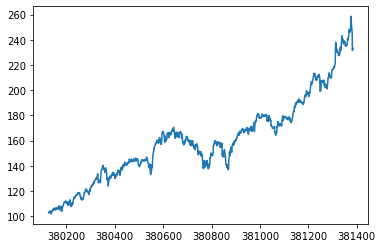

In [67]:
mmm = data[data["Name"]=="MMM"].copy()
mmm["close"].plot();

In [68]:
mmm = return_calculator(mmm,1)

In [69]:
mmm["return"].mean(), mmm["return"].std()

(0.0007001182500580143, 0.009768718404053094)

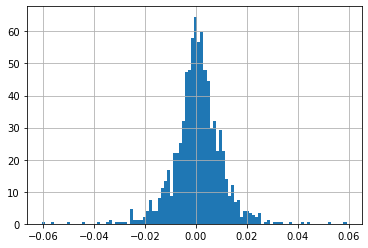

In [70]:
mmm["return"].hist(bins=100, density=True);

In [71]:
values = mmm['return'].dropna().to_numpy()
log_return_mmm = mmm["log_return"].dropna()

In [74]:
t_z_value = t_z_score(values, alpha=0.95, mode="z")

In [76]:
m, s, low, high = m_s_low_high_calculator(values, z = t_z_value)

In [77]:
print(m, s, low, high)

0.0007001182500580143 0.009768718404053094 0.00016030273684708885 0.0012399337632689397


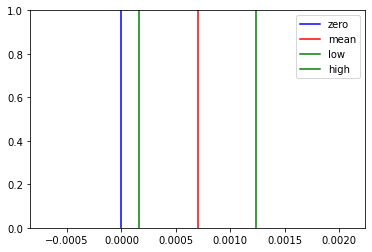

In [78]:
# mmm['return'].hist(bins=100, density=True)
plt.xlim((low - 0.001, high + 0.001))
plt.axvline(0, label='zero', color='blue')
plt.axvline(m, label='mean', color='red')
plt.axvline(low, label='low', color='green')
plt.axvline(high, label='high', color='green')
plt.legend();

In [79]:
ttest_1samp(values, 0)

Ttest_1sampResult(statistic=2.541991701703365, pvalue=0.011141496531324404)

In [80]:
ttest_1samp(log_return_mmm, 0)

Ttest_1sampResult(statistic=2.365963115873947, pvalue=0.018134246809755054)

### Covariance and Correlation

In [81]:
close = pd.read_csv("sp500_close.csv")

975

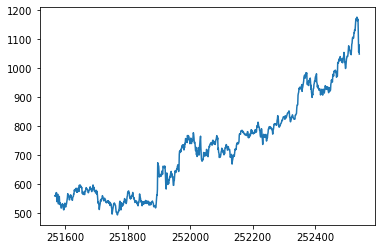

In [82]:
goog = data[data["Name"]=="GOOG"]
goog["close"].plot();
len(goog)

In [83]:
symbols = ["AAPL", "GOOG", "IBM", "NFLX", "SBUX"]
sub = close[symbols].copy()

In [84]:
sub.dropna(axis=0, how="all", inplace=True)

In [85]:
sub.head()

,AAPL,GOOG,IBM,NFLX,SBUX
0,67.8542,558.46,201.68,25.8528,28.185
1,68.5614,558.46,200.16,25.4128,28.070
2,66.8428,558.46,200.04,25.4214,28.130
3,66.7156,558.46,200.09,26.6098,27.915
4,66.6556,558.46,199.65,26.7714,27.775


In [86]:
sub = return_calculator_batch(sub,symbols,t=1)

In [87]:
rets = sub[[symbol+"_ret" for symbol in symbols]].copy()
rets.head()

,AAPL_ret,GOOG_ret,IBM_ret,NFLX_ret,SBUX_ret
0,NaN,NaN,NaN,NaN,NaN
1,0.010422,0.0,-0.007537,-0.017019,-0.004080
2,-0.025067,0.0,-0.000600,0.000338,0.002138
3,-0.001903,0.0,0.000250,0.046748,-0.007643
4,-0.000899,0.0,-0.002199,0.006073,-0.005015


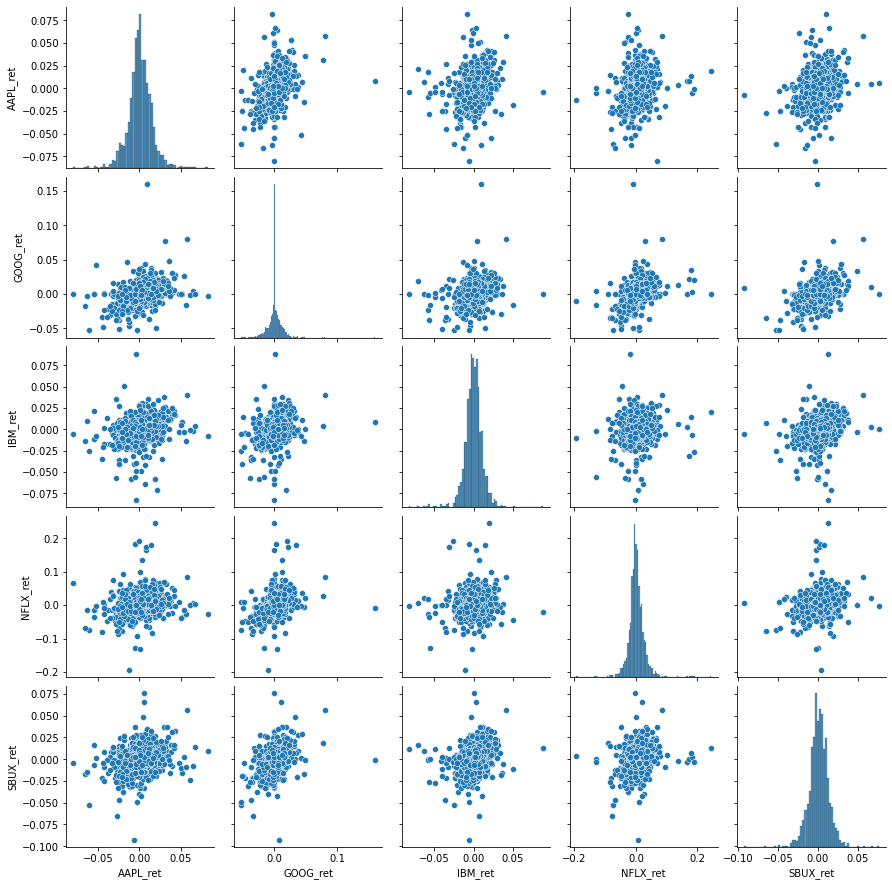

In [88]:
sns.pairplot(rets);

In [89]:
rets.mean()

AAPL_ret    0.000786
GOOG_ret    0.000576
IBM_ret    -0.000144
NFLX_ret    0.002217
SBUX_ret    0.000600
dtype: float64

In [90]:
rets.std()

AAPL_ret    0.014593
GOOG_ret    0.012382
IBM_ret     0.011876
NFLX_ret    0.027353
SBUX_ret    0.012361
dtype: float64

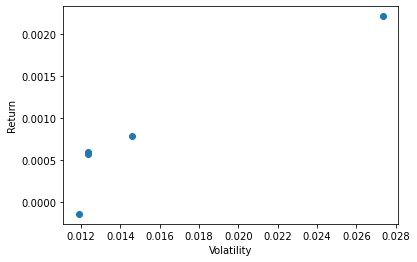

In [91]:
return_volatiliy_plot(rets)

In [92]:
rets.corr()

,AAPL_ret,GOOG_ret,IBM_ret,NFLX_ret,SBUX_ret
AAPL_ret,1.000000,0.359016,0.263927,0.227387,0.307716
GOOG_ret,0.359016,1.000000,0.305570,0.344806,0.396906
IBM_ret,0.263927,0.305570,1.000000,0.163267,0.315263
NFLX_ret,0.227387,0.344806,0.163267,1.000000,0.266012
SBUX_ret,0.307716,0.396906,0.315263,0.266012,1.000000


In [93]:
rets.cov()

,AAPL_ret,GOOG_ret,IBM_ret,NFLX_ret,SBUX_ret
AAPL_ret,0.000213,0.000065,0.000046,0.000091,0.000056
GOOG_ret,0.000065,0.000153,0.000045,0.000117,0.000061
IBM_ret,0.000046,0.000045,0.000141,0.000053,0.000046
NFLX_ret,0.000091,0.000117,0.000053,0.000748,0.000090
SBUX_ret,0.000056,0.000061,0.000046,0.000090,0.000153


### Mixture of Gaussians

In [94]:
x_list = np.linspace(-0.1, 0.1, 500)

In [95]:
def create_mx_gaussians(p, x_list, loc1, scale1, loc2, scale2):
    fx = p * norm.pdf(x_list, loc=loc1, scale=scale1) + (1-p) * norm.pdf(x_list, loc=loc2, scale=scale2)
    return fx

def sample_generator(p, loc1, scale1, loc2, scale2):
    samples = []
    m0, s0 = loc1, scale1
    m1, s1 = loc2, scale2
    
    for _ in range(5000):
        if np.random.random() < p:
            x = norm.rvs(m0, s0)
        else:
            x = norm.rvs(m1, s1)
        samples.append(x)
    series = pd.Series(samples)
    return series.kurtosis(), series

In [96]:
loc1, scale1, loc2, scale2 = 0, 0.01, 0, 0.002
p = 0.5

fx = create_mx_gaussians(p=0.5, x_list=x_list, loc1=loc1, scale1=scale1, loc2=loc2, scale2=scale2)

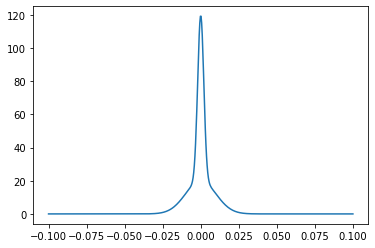

In [97]:
plt.plot(x_list, fx);

In [98]:
kurtosis, series = sample_generator(p,loc1, scale1, loc2, scale2)

In [99]:
kurtosis

2.3776795775004542

In [100]:
data = sbux["log_return"].dropna().to_numpy().reshape(-1,1)
model = GaussianMixture(n_components=2)
model.fit(data)

GaussianMixture(n_components=2)

In [101]:
weights = model.weights_
means = model.means_
cov = model.covariances_

print("weights: ", weights)
print("means:   ", means)
print("cov:     ", cov)

weights:  [0.61807517 0.38192483]
means:    [[ 0.00114856]
 [-0.00048781]]
cov:      [[[6.51181870e-05]]

 [[2.96637119e-04]]]


In [102]:
means = means.flatten()
var = cov.flatten()

In [103]:
x_list = np.linspace(data.min(), data.max(), 100)
fx0 = norm.pdf(x_list, means[0], np.sqrt(var[0]))
fx1 = norm.pdf(x_list, means[1], np.sqrt(var[1]))
fx = weights[0] * fx0 + weights[1] * fx1

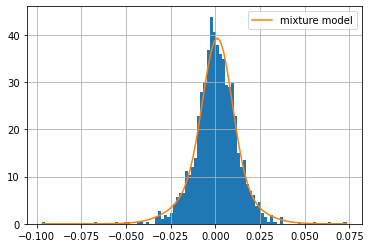

In [104]:
sbux["log_return"].hist(bins=100, density=True)
plt.plot(x_list, fx, label="mixture model")
plt.legend();

### Volatility Clustering

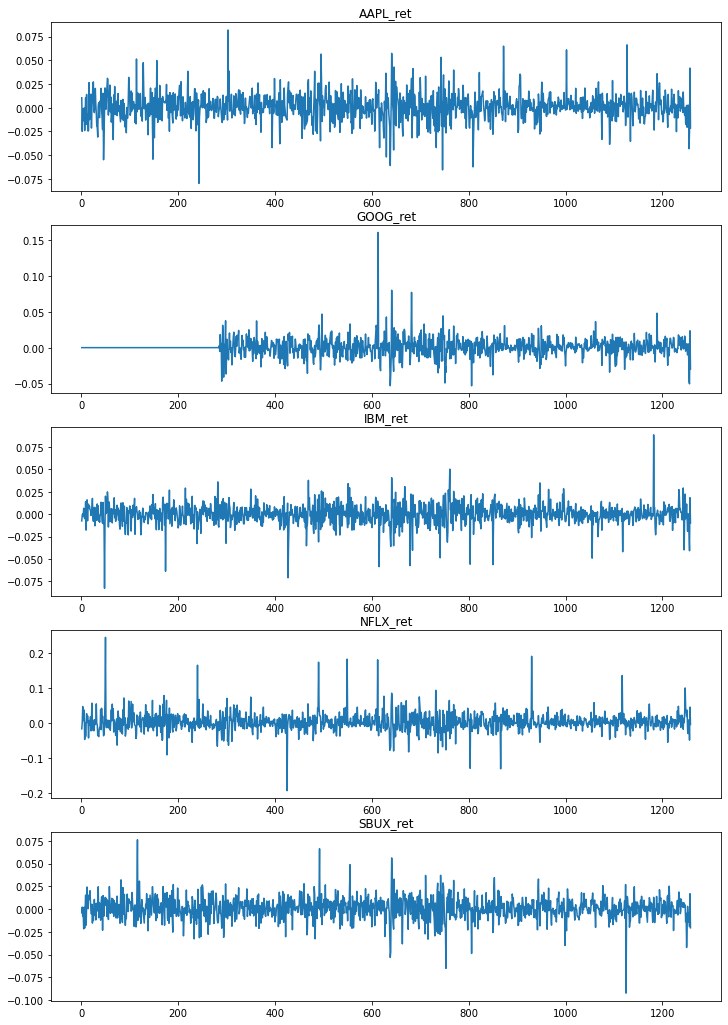

In [105]:
for i, symbol in enumerate(rets.columns):
    plt.subplot(len(rets.columns), 1, i+1)
    plt.title(symbol)
    rets[symbol].plot(figsize=(12,18));

### Price Simulation

In [106]:
p0 = sbux.iloc[-1]["close"]
prices = [p0]
returns = sbux["return"].dropna()
for _ in range(100):
    r = np.random.choice(returns)
    p = prices[-1] * (1+r)
    prices.append(p)

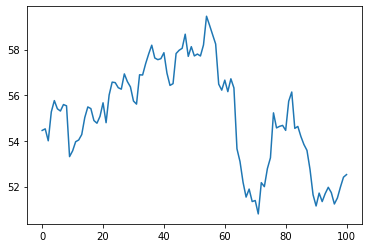

In [107]:
plt.plot(prices);

In [108]:
returns = sbux["return"].dropna()
df, loc, scale = t.fit(returns)
p0 = sbux.iloc[-1]["close"]
prices = [p0]
for _ in range(100):
    r = t.rvs(df, loc, scale)
    p = prices[-1] * (1+r)
    prices.append(p)

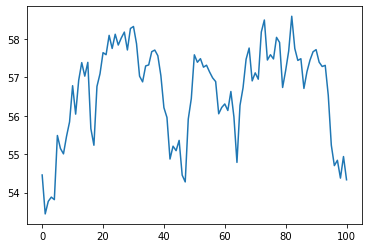

In [109]:
plt.plot(prices);